In [1]:
import pickle

import bento
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from hmr import Reloader
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, EpochScoring

bento = Reloader(bento)

plt.rcParams["figure.dpi"] = 100
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["font.family"] = "Arial"


In [2]:
import matplotlib as mpl


# Load annotated data

In [3]:
patterns = ["cell_edge", "cytoplasmic", "none", "nuclear", "nuclear_edge"]


In [4]:
seqfish = bento.io.read_h5ad(
    "../../data/multilabel_annotations/seqfish_annot_gold.h5ad"
)
merfish = bento.io.read_h5ad(
    "../../data/multilabel_annotations/merfish_annot_gold.h5ad"
)


In [5]:
def get_xy(data):
    # List of features
    features = [
        "cell_inner_proximity",
        "nucleus_inner_proximity",
        "nucleus_outer_proximity",
        "cell_inner_asymmetry",
        "nucleus_inner_asymmetry",
        "nucleus_outer_asymmetry",
        "l_max",
        "l_max_gradient",
        "l_min_gradient",
        "l_monotony",
        "l_half_radius",
        "point_dispersion",
        "nucleus_dispersion",
    ]

    sample_index = (
        data.to_df("cell_edge")
        .reset_index()
        .melt(id_vars="cell")
        .dropna()
        .set_index(["cell", "gene"])
        .drop("value", axis=1)
    )
    for p in [*patterns, *features]:
        values = (
            data.to_df(p).reset_index().melt(id_vars="cell").set_index(["cell", "gene"])
        )
        values.columns = [p]
        sample_index = sample_index.join(values)

    return sample_index[patterns].astype(int), sample_index[features]


In [6]:
y_seqfish, X_seqfish = get_xy(seqfish)
y_merfish, X_merfish = get_xy(merfish)


In [7]:
y_freqs = pd.concat([y_seqfish.sum(), y_merfish.sum()], axis=1)
y_freqs.columns = ["seqfish", "merfish"]
y_freqs = y_freqs.reset_index().melt("index")
y_freqs.columns = ["pattern", "dataset", "count"]


In [8]:
n_seqfish = len(y_seqfish)
n_merfish = len(y_merfish)


In [9]:
y_true = np.concatenate([y_seqfish, y_merfish], axis=0)
y_true.shape


(380, 5)

In [10]:
X = np.concatenate([X_seqfish, X_merfish], axis=0)
X.shape


(380, 13)

In [11]:
from torchvision import datasets, transforms

dataset = datasets.ImageFolder(
    "../../data/multilabel_annotations/seqfish_img",
    transform=transforms.Compose([transforms.Grayscale(), transforms.ToTensor()]),
)
X_img_seqfish = np.array([x[0].numpy() for x in dataset])

cells = []
genes = []
for path in dataset.imgs:
    cell = path[0].split("/")[-1].split("_")[0]
    gene = path[0].split("/")[-1].split("_")[1].split(".tif")[0]

    cells.append(cell)
    genes.append(gene)

seqfish_index = (
    pd.DataFrame([cells, genes], index=["cell", "gene"])
    .T.reset_index()
    .set_index(["cell", "gene"])
)

keep = X_seqfish.join(seqfish_index)["index"].tolist()
X_img_seqfish = X_img_seqfish[keep]


dataset = datasets.ImageFolder(
    "../../data/multilabel_annotations/merfish_img",
    transform=transforms.Compose([transforms.Grayscale(), transforms.ToTensor()]),
)
X_img_merfish = np.array([x[0].numpy() for x in dataset])

cells = []
genes = []
for path in dataset.imgs:
    cell = path[0].split("/")[-1].split("_")[0]
    gene = path[0].split("/")[-1].split("_")[1].split(".tif")[0]

    cells.append(cell)
    genes.append(gene)

merfish_index = (
    pd.DataFrame([cells, genes], index=["cell", "gene"])
    .T.reset_index()
    .set_index(["cell", "gene"])
)

keep = X_merfish.join(merfish_index)["index"].tolist()
X_img_merfish = X_img_merfish[keep]


In [12]:
X_img = np.concatenate([X_img_seqfish, X_img_merfish])


# NN architectures

In [13]:
class FCModule(nn.Module):
    def __init__(
        self,
        l0_size,
        l1_size,
    ):
        super().__init__()
        fc_layers = []
        in_features = 13

        # Hidden layers
        for layer_size in [l0_size, l1_size]:
            fc_layers.extend(
                [
                    nn.Linear(in_features, layer_size),
                    nn.BatchNorm1d(layer_size),
                    nn.Dropout(0.2),
                    nn.ReLU(),
                ]
            )

            in_features = layer_size

        # Output layer
        fc_layers.append(nn.Linear(in_features, 2))
        self.model = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.model(x.float())
        x = F.softmax(x, dim=-1)
        return x


In [14]:
def get_conv_dim(in_size, padding, dilation, kernel_size, stride):
    outsize = 1 + (in_size + 2 * padding - dilation * (kernel_size - 1) - 1) / stride
    return int(outsize)


class SpotsBinaryModule(nn.Module):
    def __init__(
        self,
        n_conv_layers,
        in_dim,
        out_channels,
        kernel_size,
        f_units_l0,
        f_units_l1,
    ) -> None:
        super().__init__()
        conv_layers = []

        in_channels = 1
        in_dim = in_dim

        # Stack (convolutions + batchnorm + activation) + maxpool
        for i in range(n_conv_layers):
            conv_layers.extend(
                [
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=kernel_size,
                    ),
                    nn.BatchNorm2d(out_channels),
                    nn.Dropout(0.2),
                    nn.ReLU(),
                ]
            )

            # Compute convolved output dimensions
            in_dim = get_conv_dim(
                in_dim, padding=0, dilation=1, kernel_size=kernel_size, stride=1
            )

            in_channels = out_channels
            out_channels *= 2

        out_channels = int(out_channels / 2)

        conv_layers.append(nn.MaxPool2d(2, 2))
        in_dim = int(in_dim / 2)

        # We optimize the number of layers, hidden units and dropout ratio in each layer.
        fc_layers = [nn.Flatten()]

        # Compute flatten size
        in_features = out_channels * in_dim * in_dim
        for i in [f_units_l0, f_units_l1]:
            out_features = i
            fc_layers.extend(
                [
                    nn.Linear(in_features, out_features),
                    nn.BatchNorm1d(out_features),
                    nn.Dropout(0.2),
                    nn.ReLU(),
                ]
            )

            in_features = out_features

        fc_layers.append(nn.Linear(in_features, 2))
        self.model = torch.nn.Sequential(*[*conv_layers, *fc_layers])

    def forward(self, x):
        x = self.model(x)
        x = F.softmax(x, dim=-1)
        return x


# Load models

In [15]:
model_dir = "../../models/ml_multilabel_20211102"

rf_model = pickle.load(open(f"{model_dir}/rf_model.pkl", "rb"))
svc_model = pickle.load(open(f"{model_dir}/svc_model.pkl", "rb"))
nn_model = pickle.load(open(f"{model_dir}/nn_model.pkl", "rb"))
cnn_model = pickle.load(open(f"{model_dir}/cnn_model.pkl", "rb"))

classifiers = [rf_model, svc_model, nn_model, cnn_model]
classifier_names = ["RF", "SVM", "NN", "CNN"]


# Performance

In [16]:
predict = []
for c in classifiers[:3]:
    predict.append(c.predict_proba(X))

predict.append(cnn_model.predict_proba(X_img))


In [18]:
from sklearn.metrics import multilabel_confusion_matrix


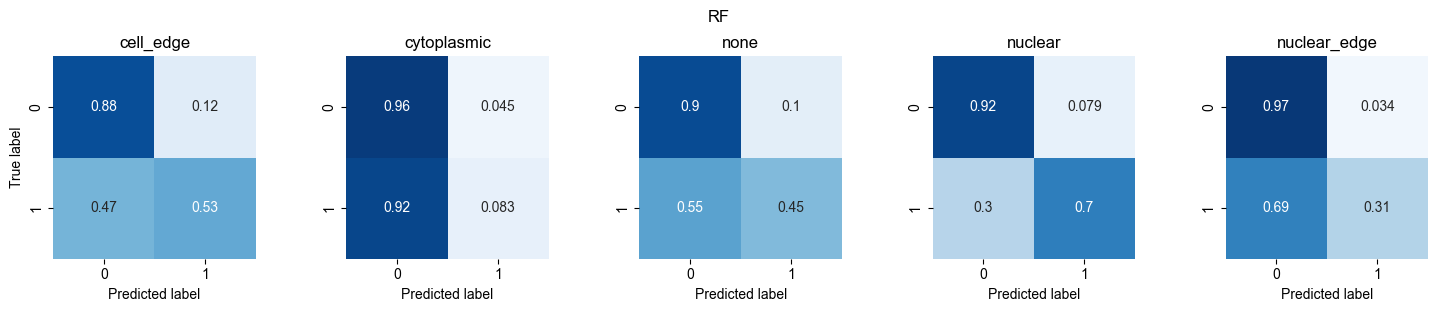

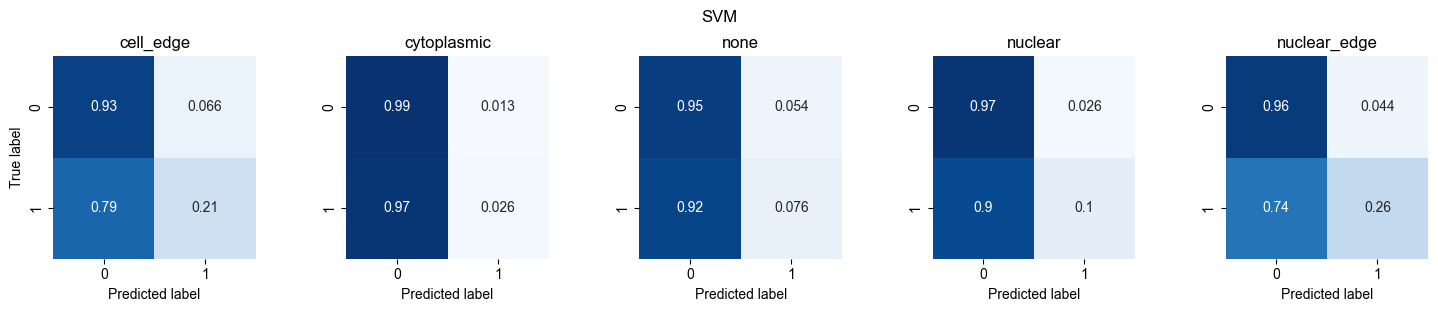

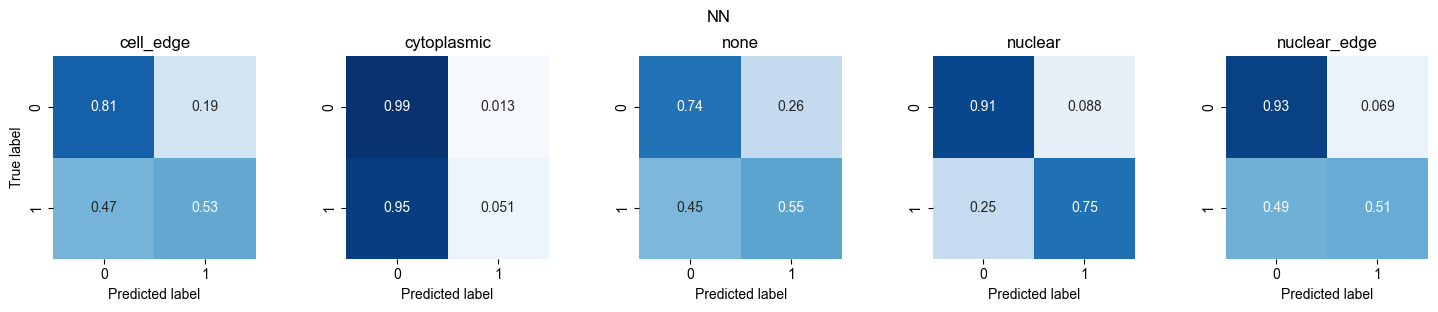

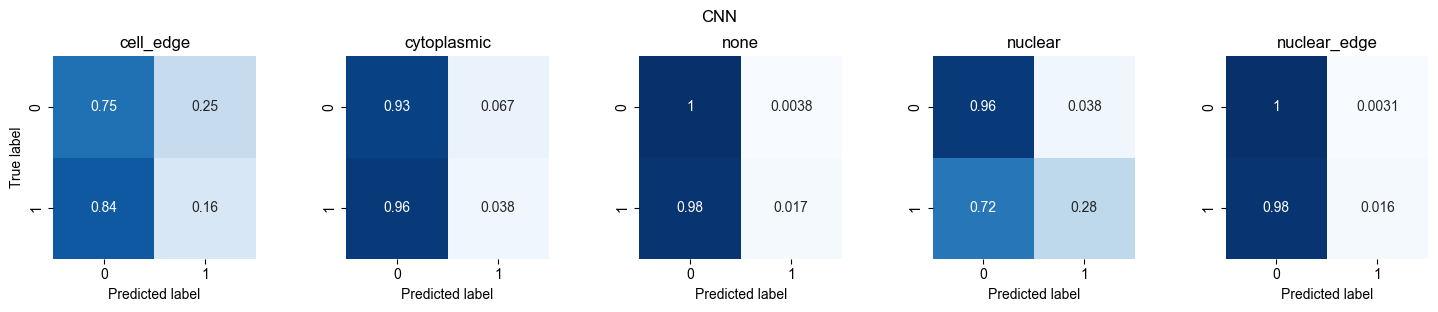

In [19]:
for pred, cname in zip(predict, classifier_names):
    multi_confusion = multilabel_confusion_matrix(y_true, pred > 0.5)
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    plt.suptitle(cname, weight="600")
    for i, mtx in enumerate(multi_confusion):
        ax = axes[i]
        mtx_norm = mtx / mtx.sum(axis=1).reshape(-1, 1)
        sns.heatmap(
            mtx_norm,
            ax=ax,
            square=True,
            cmap="Blues",
            cbar=None,
            annot=True,
            vmin=0,
            vmax=1,
        )

        ax.set_xlabel("Predicted label")
        ax.set_title(patterns[i])

        if ax.is_first_col():
            ax.set_ylabel("True label")

    plt.tight_layout()


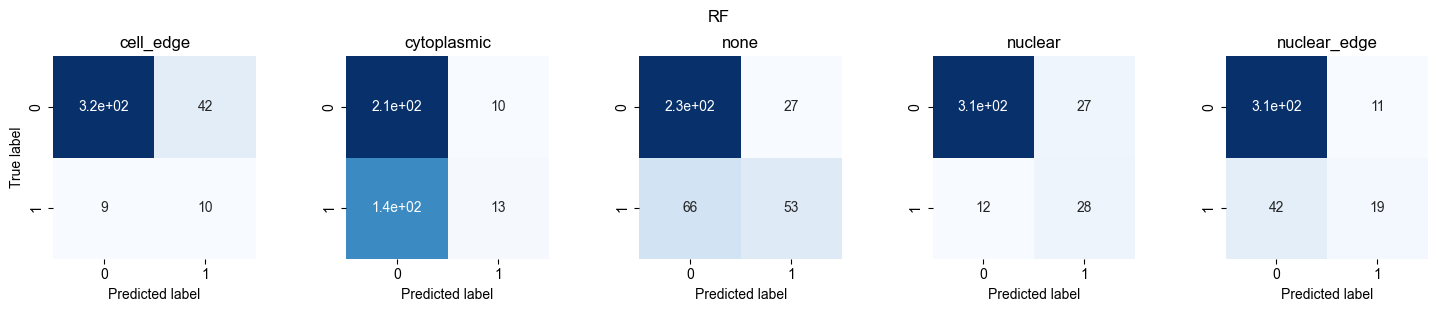

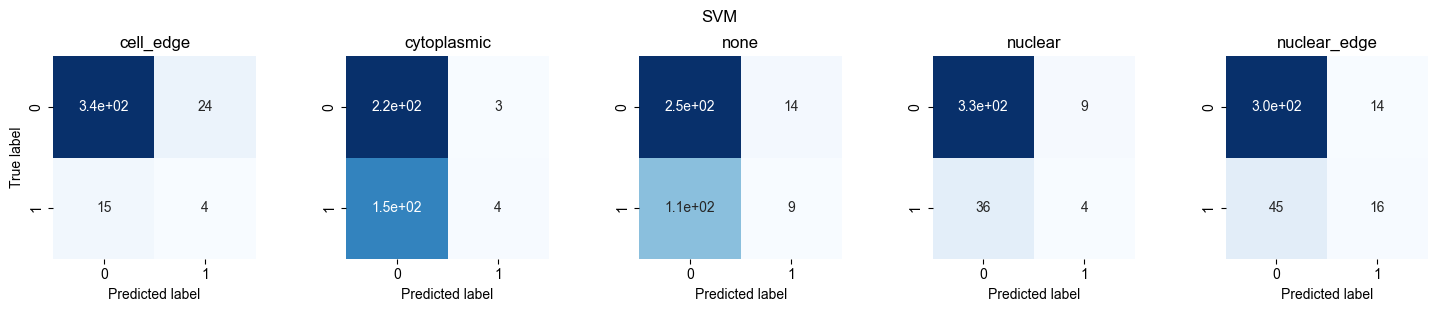

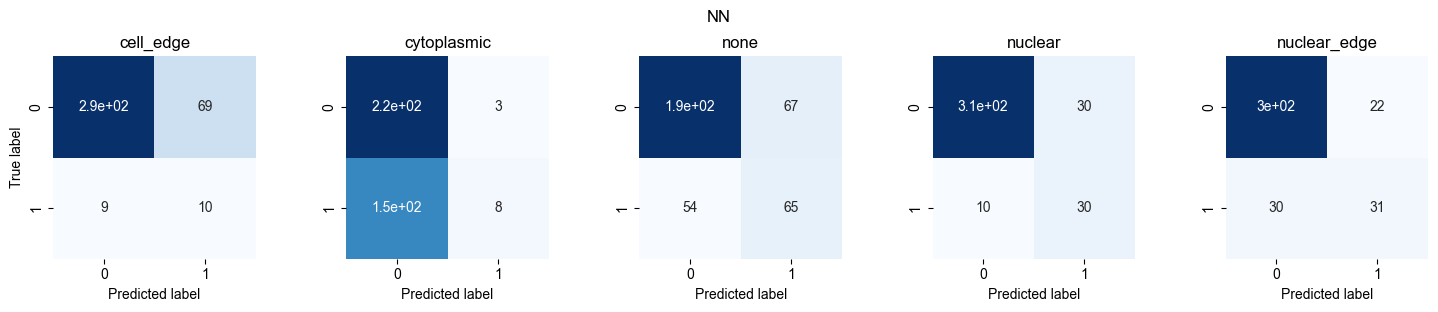

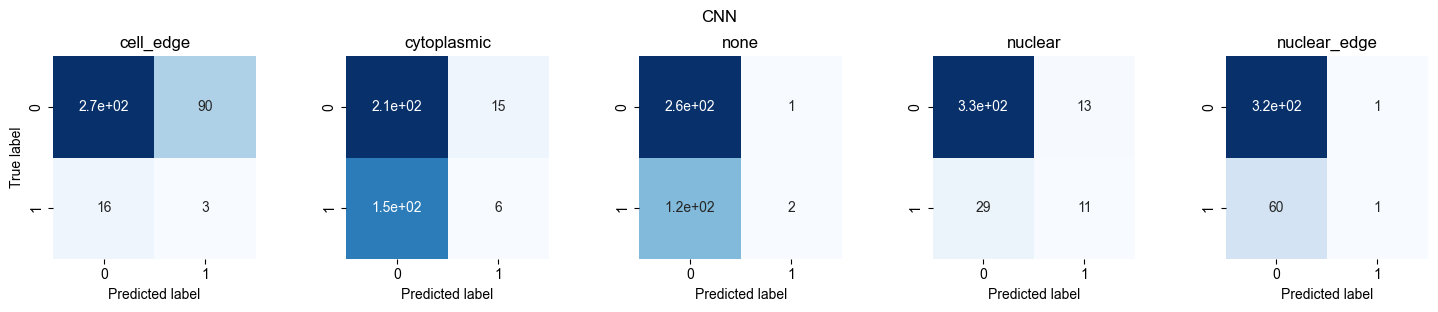

In [20]:
for pred, cname in zip(predict, classifier_names):
    multi_confusion = multilabel_confusion_matrix(y_true, pred > 0.5)
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    plt.suptitle(cname, weight="600")
    for i, mtx in enumerate(multi_confusion):
        ax = axes[i]
        sns.heatmap(
            mtx,
            ax=ax,
            square=True,
            cmap="Blues",
            cbar=None,
            annot=True,
            # vmin=0,
            # vmax=1,
        )

        ax.set_xlabel("Predicted label")
        ax.set_title(patterns[i])

        if ax.is_first_col():
            ax.set_ylabel("True label")

    plt.tight_layout()


## AUC

In [17]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import auc, roc_curve

fpr = dict()
tpr = dict()
roc_auc = dict()

for c, cname, pred in zip(classifiers, classifier_names, predict):
    fpr[cname] = dict()
    tpr[cname] = dict()
    roc_auc[cname] = dict()

    fpr[cname]["all"], tpr[cname]["all"], _ = roc_curve(y_true.ravel(), pred.ravel())
    roc_auc[cname]["all"] = auc(fpr[cname]["all"], tpr[cname]["all"])

    fpr[cname]["seqfish"], tpr[cname]["seqfish"], _ = roc_curve(
        y_true[:n_seqfish].ravel(), pred[:n_seqfish].ravel()
    )
    roc_auc[cname]["seqfish"] = auc(fpr[cname]["seqfish"], tpr[cname]["seqfish"])

    fpr[cname]["merfish"], tpr[cname]["merfish"], _ = roc_curve(
        y_true[-n_merfish:].ravel(), pred[-n_merfish:].ravel()
    )
    roc_auc[cname]["merfish"] = auc(fpr[cname]["merfish"], tpr[cname]["merfish"])

    for i in range(len(patterns)):
        fpr[cname][i], tpr[cname][i], _ = roc_curve(y_true[:, i], pred[:, i])
        roc_auc[cname][i] = auc(fpr[cname][i], tpr[cname][i])


In [18]:
classifier_aucs = {}
for cname in classifier_names:
    classifier_aucs[cname] = [roc_auc[cname]["all"]]

classifier_aucs = pd.DataFrame(classifier_aucs).T.reset_index()
classifier_aucs.columns = ["model", "AUC_ROC"]


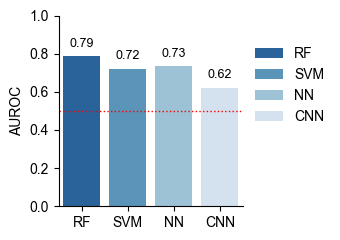

In [48]:
plt.figure(figsize=(3.5, 2.5))
ax = sns.barplot(
    data=classifier_aucs,
    x="model",
    y="AUC_ROC",
    hue="model",
    errwidth=0,
    dodge=False,
    palette="Blues_r",
)
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ".2f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 9),
        textcoords="offset points",
        fontsize=9,
    )
ax.legend(bbox_to_anchor=(1, 0.9), frameon=False)
ax.set_ylim(0, 1)
ax.axhline(0.5, c="red", linestyle=":", lw=1)
ax.set(xlabel=None)
ax.set(ylabel='AUROC')
sns.despine()
plt.tight_layout()
plt.savefig("../../figures/fig2_auc.svg")


In [21]:
classifier_aucs = {}
for cname in classifier_names:
    classifier_aucs[cname] = [roc_auc[cname]["seqfish"], roc_auc[cname]["merfish"]]

classifier_aucs = (
    pd.DataFrame(classifier_aucs, index=["seqfish", "merfish"])
    .T.reset_index()
    .melt("index")
)
classifier_aucs.columns = ["model", "dataset", "AUC_ROC"]


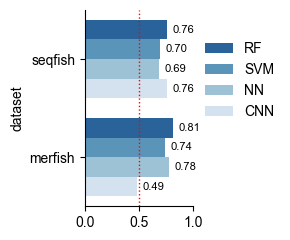

In [43]:
plt.figure(figsize=(3, 2.5))
ax = sns.barplot(
    data=classifier_aucs, y="dataset", x="AUC_ROC", hue="model", palette="Blues_r"
)
for p in ax.patches:
    ax.annotate(
        format(p.get_width(), ".2f"),
        (p.get_width() + 0.1, p.get_y() - (p.get_height() / 2.0)),
        ha="center",
        va="center",
        xytext=(0, 0),
        textcoords="offset points",
        fontsize=8,
    )
ax.legend(bbox_to_anchor=(1, 0.9), frameon=False)
ax.set_xlim(0, 1)
ax.axvline(0.5, c="red", linestyle=":", lw=1)
ax.set(xlabel=None)
sns.despine()
plt.tight_layout()
plt.savefig("../../figures/fig2_auc_stratified.svg")


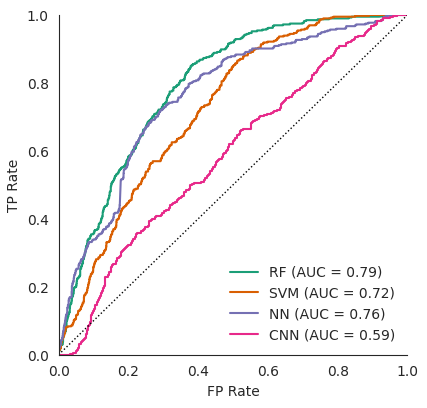

In [48]:
# Plot all ROC curves
import matplotlib.pyplot as plt
import seaborn as sns

with sns.axes_style("white"):
    plt.figure(figsize=(4.5, 4.5))

    colors = sns.color_palette("Dark2", n_colors=len(classifier_names))
    for cname, color in zip(classifier_names, colors):
        plt.plot(
            fpr[cname]["all"],
            tpr[cname]["all"],
            label=f"{cname} (AUC = {roc_auc[cname]['all']:0.2f})",
            color=color,
            linestyle="-",
            linewidth=1.5,
        )
    plt.plot([0, 1], [0, 1], ":", c="black", lw=1)

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel("FP Rate")
    plt.ylabel("TP Rate")
    plt.legend(loc="lower right", frameon=False, fontsize=10)
    sns.despine()
    plt.savefig("../../figures/fig2_roc.svg")


## Precision Recall

In [27]:
from sklearn.metrics import (
    PrecisionRecallDisplay,
    average_precision_score,
    f1_score,
    precision_recall_curve,
)

# For each class
precision = dict()
recall = dict()
average_precision = dict()
macro_f1 = dict()

for c, cname, pred in zip(classifiers, classifier_names, predict):
    precision[cname] = dict()
    recall[cname] = dict()
    average_precision[cname] = dict()

    for i in range(len(patterns)):
        precision[cname][i], recall[cname][i], _ = precision_recall_curve(
            y_true[:, i], pred[:, i]
        )
        average_precision[cname][i] = average_precision_score(y_true[:, i], pred[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision[cname]["micro"], recall[cname]["micro"], _ = precision_recall_curve(
        y_true.ravel(), pred.ravel()
    )
    average_precision[cname]["micro"] = average_precision_score(
        y_true, pred, average="micro"
    )

    macro_f1[cname] = dict()

    macro_f1[cname]["seqfish"] = f1_score(
        y_true[:n_seqfish], pred[:n_seqfish] > 0.5, average="macro"
    )
    macro_f1[cname]["merfish"] = f1_score(
        y_true[-n_merfish:], pred[-n_merfish:] > 0.5, average="macro"
    )

macro_f1 = (
    pd.DataFrame(macro_f1, index=["seqfish", "merfish"]).T.reset_index().melt("index")
)
macro_f1.columns = ["model", "dataset", "Macro_F1"]


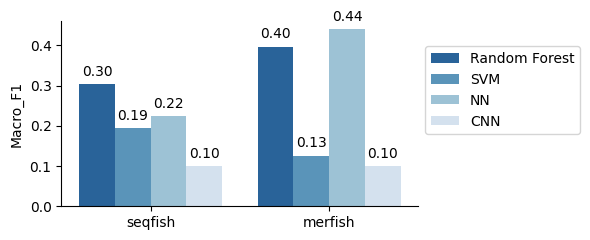

In [28]:
plt.rcParams["figure.dpi"] = 100
plt.figure(figsize=(6, 2.5))
ax = sns.barplot(
    data=macro_f1, x="dataset", y="Macro_F1", hue="model", palette="Blues_r"
)
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ".2f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 9),
        textcoords="offset points",
    )
ax.legend(bbox_to_anchor=(1, 0.9))
ax.set(xlabel=None)
sns.despine()
plt.tight_layout()
plt.savefig("../../figures/fig2_macrof1.svg")


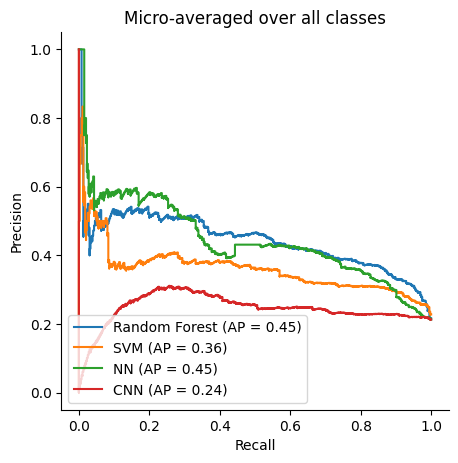

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for cname in classifier_names:
    display = PrecisionRecallDisplay(
        recall=recall[cname]["micro"],
        precision=precision[cname]["micro"],
        average_precision=average_precision[cname]["micro"],
    )
    display.plot(ax=ax, name=cname)
    _ = display.ax_.set_title("Micro-averaged over all classes")

sns.despine()


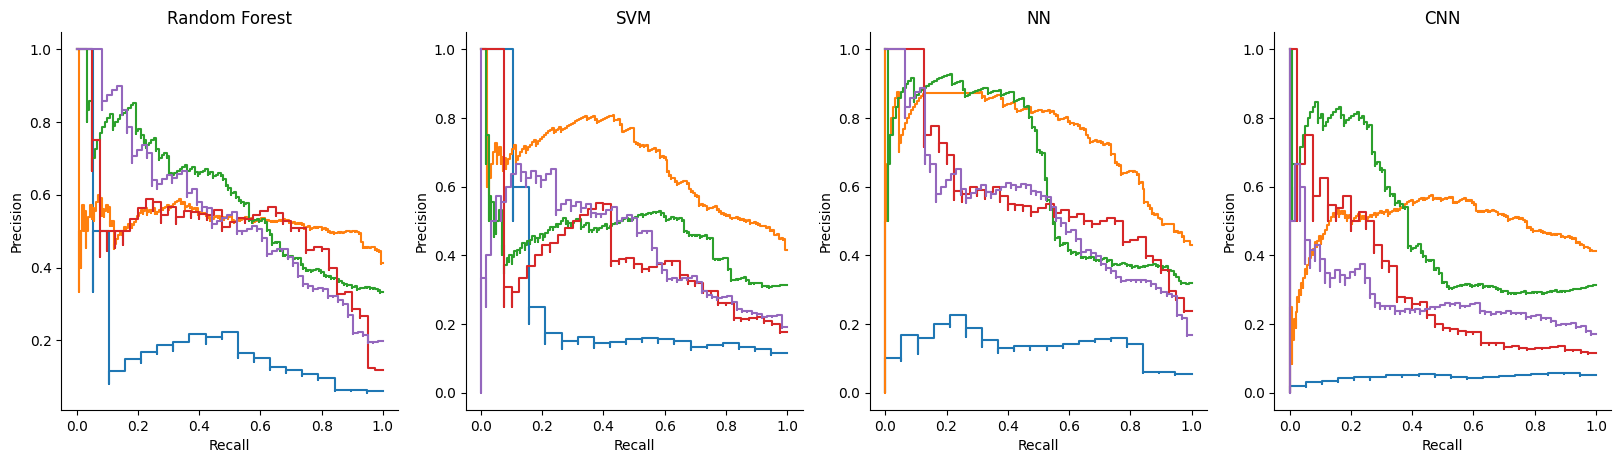

In [30]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for cname, ax in zip(classifier_names, axes):
    for i, color in zip(range(len(patterns)), colors):
        display = PrecisionRecallDisplay(
            recall=recall[cname][i],
            precision=precision[cname][i],
            average_precision=average_precision[cname][i],
        )
        display.plot(ax=ax, name=f"{patterns[i]}", color=color)
        ax.get_legend().remove()
        ax.set_title(cname)
    sns.despine()


## Sparsity Analysis

In [31]:
from sklearn.metrics import f1_score
from tqdm.auto import tqdm


In [32]:
counts_seqfish = (
    seqfish.to_df()
    .reset_index()
    .melt("cell")
    .set_index(["cell", "gene"])
    .loc[X_seqfish.index]
)
counts_merfish = (
    merfish.to_df()
    .reset_index()
    .melt("cell")
    .set_index(["cell", "gene"])
    .loc[X_merfish.index]
)
counts = pd.concat([counts_seqfish, counts_merfish])
max_counts = int(counts.max())


In [33]:
read_scores = dict()
for c, cname, pred in zip(classifiers, classifier_names, predict):
    read_scores[cname] = []
    for i in tqdm(range(len(patterns))):
        for threshold in range(5, 100, 2):
            count_mask = (counts <= threshold).values.flatten().tolist()
            score = f1_score(
                y_true[count_mask, i], pred[count_mask, i] > 0.5, average="micro"
            )
            read_scores[cname].append([patterns[i], threshold, score])
    read_scores[cname] = pd.DataFrame(
        read_scores[cname], columns=["pattern", "min_count", "f1score"]
    )


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
fig, axes = plt.subplots(1, len(read_scores), figsize=(20, 5))

for (cname, score_df), ax in zip(read_scores.items(), axes):

    sns.lineplot(
        data=score_df,
        x="min_count",
        y="f1score",
        hue="pattern",
        palette="muted6",
        ax=ax,
        #         legend=False,
    )
    ax.set_title(cname)
    sns.despine()


# seqFISH performance

In [16]:
predict = []
for c in classifiers[:3]:
    predict.append(c.predict_proba(X_seqfish))

predict.append(cnn_model.predict_proba(X_img_seqfish))


## AUC

In [17]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import auc, roc_curve

fpr = dict()
tpr = dict()
roc_auc = dict()

for c, cname, pred in zip(classifiers, classifier_names, predict):
    fpr[cname] = dict()
    tpr[cname] = dict()
    roc_auc[cname] = dict()

    fpr[cname]["all"], tpr[cname]["all"], _ = roc_curve(
        y_seqfish.values.ravel(), pred.ravel()
    )
    roc_auc[cname]["all"] = auc(fpr[cname]["all"], tpr[cname]["all"])

    for i in range(len(patterns)):
        fpr[cname][i], tpr[cname][i], _ = roc_curve(y_seqfish.values[:, i], pred[:, i])
        roc_auc[cname][i] = auc(fpr[cname][i], tpr[cname][i])


In [18]:
classifier_aucs = {}
for cname in classifier_names:
    classifier_aucs[cname] = roc_auc[cname]["all"]


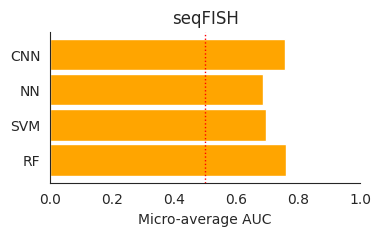

In [58]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(4, 2))
    ax.barh(
        y=list(classifier_aucs.keys()),
        width=classifier_aucs.values(),
        height=0.9,
        color="orange",
    )
    ax.axvline(0.5, color="red", linestyle=":", lw=1)
    sns.despine()
    plt.xlim(0, 1)
    ax.set_xlabel("Micro-average AUC")
    ax.set_title("seqFISH")


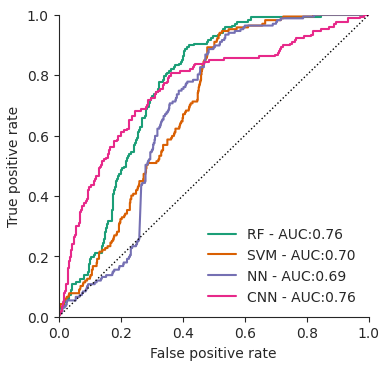

In [19]:
# Plot all ROC curves
import matplotlib.pyplot as plt
import seaborn as sns

with sns.axes_style("ticks"):
    plt.figure(figsize=(4, 4))

    colors = sns.color_palette("Dark2", n_colors=len(classifier_names))
    for cname, color in zip(classifier_names, colors):
        plt.plot(
            fpr[cname]["all"],
            tpr[cname]["all"],
            label=f"{cname} - AUC:{roc_auc[cname]['all']:0.2f}",
            color=color,
            linestyle="-",
            linewidth=1.5,
        )
    plt.plot([0, 1], [0, 1], ":", c="black", lw=1)

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend(loc="lower right", frameon=False, fontsize=10)
    sns.despine()
    plt.savefig("../../figures/fig2_auc_seqfish.svg")


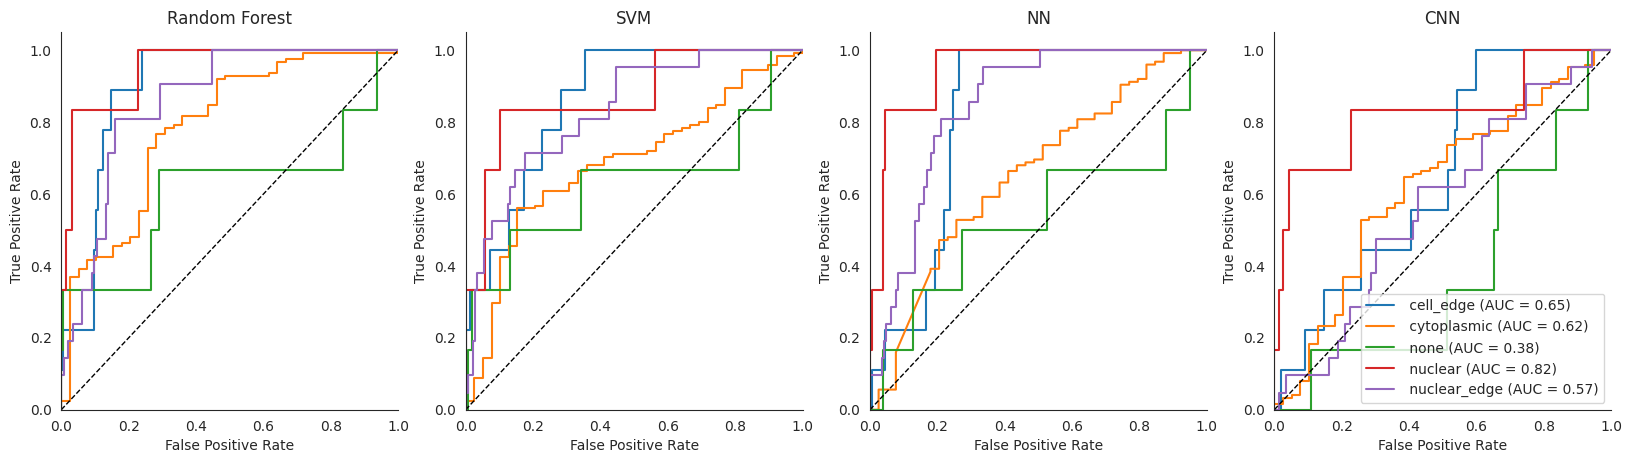

In [40]:
with sns.axes_style("white"):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for cname, ax in zip(classifier_names, axes):

        colors = sns.color_palette(n_colors=len(patterns))
        for i, color in zip(range(len(patterns)), colors):
            ax.plot(
                fpr[cname][i],
                tpr[cname][i],
                color=color,
                lw=1.5,
                label=" {0} (AUC = {1:0.2f})" "".format(patterns[i], roc_auc[cname][i]),
            )

        ax.plot([0, 1], [0, 1], "k--", lw=1)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(cname)
        plt.legend(loc="lower right")
        sns.despine()


## Precision Recall

In [41]:
from sklearn.metrics import (
    PrecisionRecallDisplay,
    average_precision_score,
    f1_score,
    precision_recall_curve,
)

# For each class
precision = dict()
recall = dict()
average_precision = dict()
macro_f1 = dict()

for c, cname, pred in zip(classifiers, classifier_names, predict):
    precision[cname] = dict()
    recall[cname] = dict()
    average_precision[cname] = dict()

    for i in range(len(patterns)):
        precision[cname][i], recall[cname][i], _ = precision_recall_curve(
            y_seqfish.values[:, i], pred[:, i]
        )
        average_precision[cname][i] = average_precision_score(
            y_seqfish.values[:, i], pred[:, i]
        )

    # A "micro-average": quantifying score on all classes jointly
    precision[cname]["micro"], recall[cname]["micro"], _ = precision_recall_curve(
        y_seqfish.values.ravel(), pred.ravel()
    )
    average_precision[cname]["micro"] = average_precision_score(
        y_seqfish.values, pred, average="micro"
    )

    macro_f1[cname] = f1_score(y_seqfish.values, pred > 0.5, average="macro")


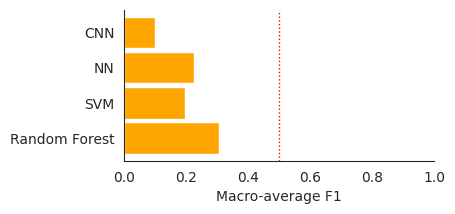

In [42]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(4, 2))
    ax.barh(
        y=list(macro_f1.keys()),
        width=macro_f1.values(),
        height=0.9,
        color="orange",
    )
    ax.axvline(0.5, color="red", linestyle=":", lw=1)
    sns.despine()
    plt.xlim(0, 1)
    ax.set_xlabel("Macro-average F1")


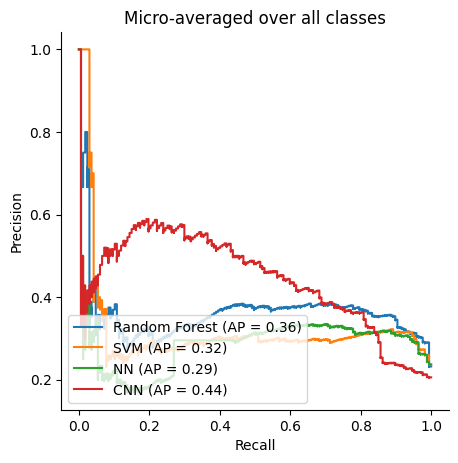

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for cname in classifier_names:
    display = PrecisionRecallDisplay(
        recall=recall[cname]["micro"],
        precision=precision[cname]["micro"],
        average_precision=average_precision[cname]["micro"],
    )
    display.plot(ax=ax, name=cname)
    _ = display.ax_.set_title("Micro-averaged over all classes")

sns.despine()


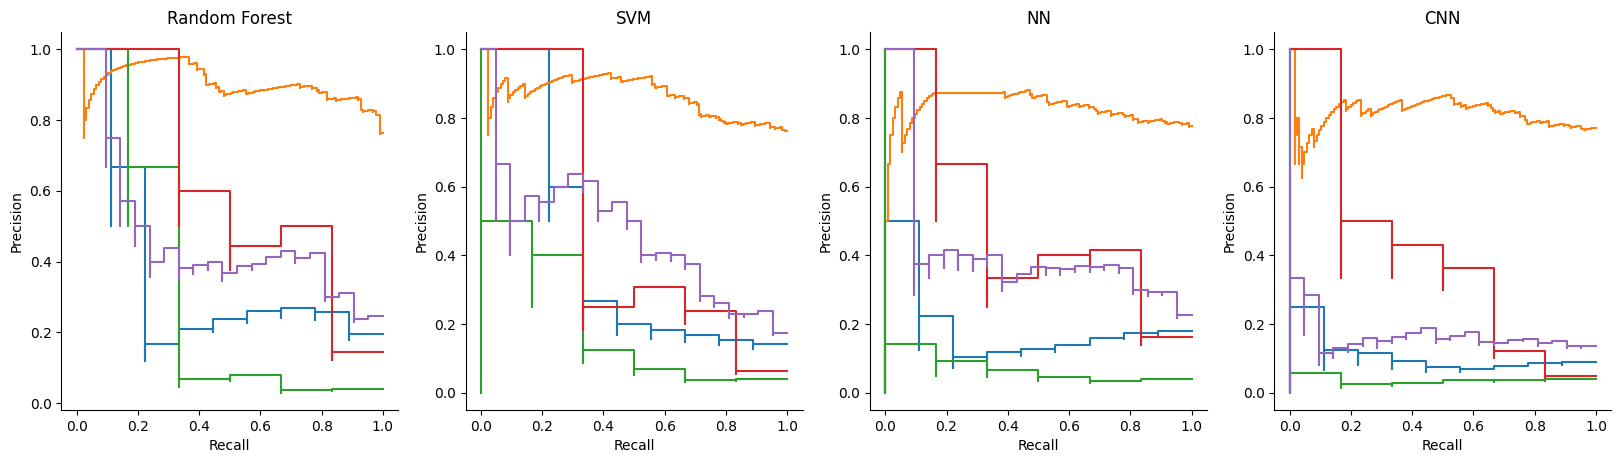

In [44]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for cname, ax in zip(classifier_names, axes):

    for i, color in zip(range(len(patterns)), colors):
        display = PrecisionRecallDisplay(
            recall=recall[cname][i],
            precision=precision[cname][i],
            average_precision=average_precision[cname][i],
        )
        display.plot(ax=ax, name=f"{patterns[i]}", color=color)
        ax.set_title(cname)
        ax.get_legend().remove()
    sns.despine()


## Sparsity Analysis

In [45]:
read_scores = dict()
for c, cname, pred in zip(classifiers, classifier_names, predict):
    read_scores[cname] = []
    for i in tqdm(range(len(patterns))):
        for threshold in range(5, 100, 2):
            count_mask = (counts_seqfish <= threshold).values.flatten().tolist()
            score = f1_score(
                y_seqfish.values[count_mask, i],
                pred[count_mask, i] > 0.5,
                average="micro",
            )
            read_scores[cname].append([patterns[i], threshold, score])
    read_scores[cname] = pd.DataFrame(
        read_scores[cname], columns=["pattern", "min_count", "f1score"]
    )


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

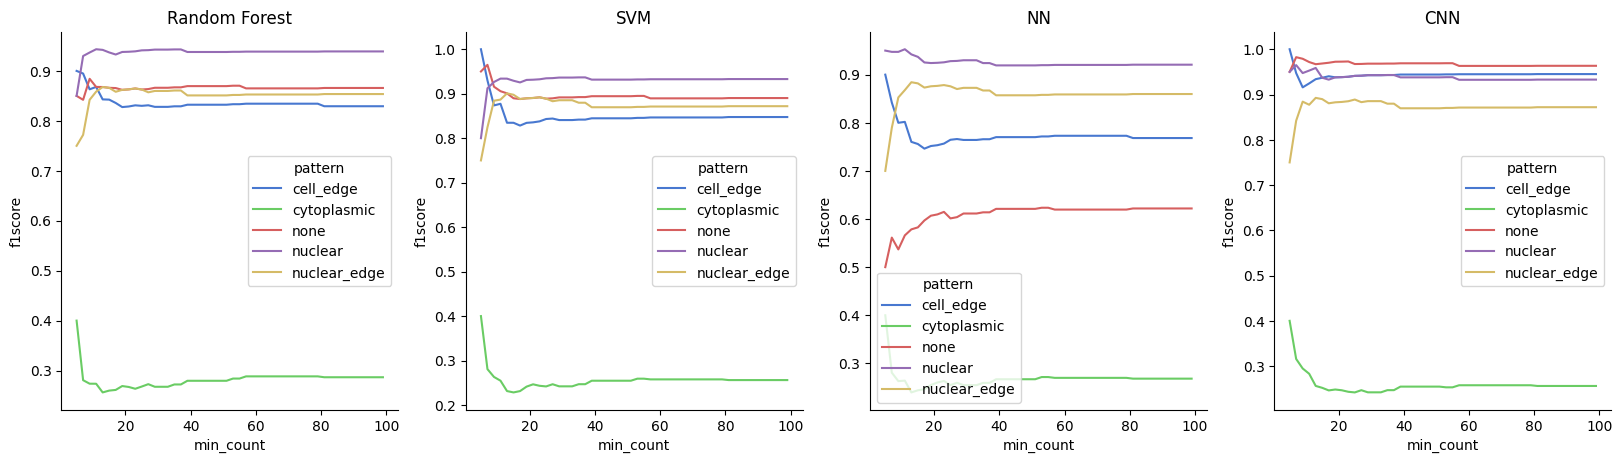

In [46]:
fig, axes = plt.subplots(1, len(read_scores), figsize=(20, 5))

for (cname, score_df), ax in zip(read_scores.items(), axes):
    sns.lineplot(
        data=score_df,
        x="min_count",
        y="f1score",
        hue="pattern",
        palette="muted6",
        ax=ax,
        #         legend=False,
    )
    ax.set_title(cname)
    sns.despine()


# MERFISH performance 

In [20]:
predict = []
for c in classifiers[:3]:
    predict.append(c.predict_proba(X_merfish))

predict.append(cnn_model.predict_proba(X_img_merfish))


## AUC

In [21]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import auc, roc_curve

fpr = dict()
tpr = dict()
roc_auc = dict()

for c, cname, pred in zip(classifiers, classifier_names, predict):
    fpr[cname] = dict()
    tpr[cname] = dict()
    roc_auc[cname] = dict()

    fpr[cname]["all"], tpr[cname]["all"], _ = roc_curve(
        y_merfish.values.ravel(), pred.ravel()
    )
    roc_auc[cname]["all"] = auc(fpr[cname]["all"], tpr[cname]["all"])

    for i in range(len(patterns)):
        fpr[cname][i], tpr[cname][i], _ = roc_curve(y_merfish.values[:, i], pred[:, i])
        roc_auc[cname][i] = auc(fpr[cname][i], tpr[cname][i])


In [22]:
classifier_aucs = {}
for cname in classifier_names:
    classifier_aucs[cname] = roc_auc[cname]["all"]


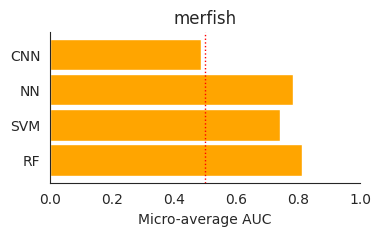

In [42]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(4, 2))
    ax.barh(
        y=list(classifier_aucs.keys()),
        width=classifier_aucs.values(),
        height=0.9,
        color="orange",
    )
    ax.axvline(0.5, color="red", linestyle=":", lw=1)
    sns.despine()
    plt.xlim(0, 1)
    ax.set_xlabel("Micro-average AUC")
    ax.set_title("merfish")


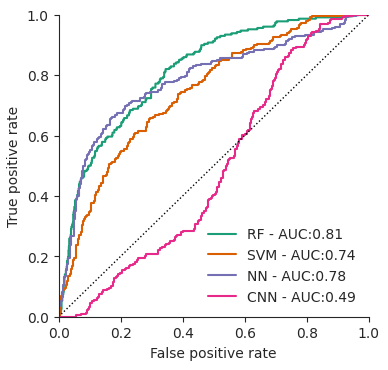

In [24]:
# Plot all ROC curves
import matplotlib.pyplot as plt
import seaborn as sns

with sns.axes_style("ticks"):
    plt.figure(figsize=(4, 4))

    colors = sns.color_palette("Dark2", n_colors=len(classifier_names))
    for cname, color in zip(classifier_names, colors):
        plt.plot(
            fpr[cname]["all"],
            tpr[cname]["all"],
            label=f"{cname} - AUC:{roc_auc[cname]['all']:0.2f}",
            color=color,
            linestyle="-",
            linewidth=1.5,
        )
    plt.plot([0, 1], [0, 1], ":", c="black", lw=1)

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend(loc="lower right", frameon=False, fontsize=10)
    sns.despine()
    plt.savefig("../../figures/fig2_auc_merfish.svg")


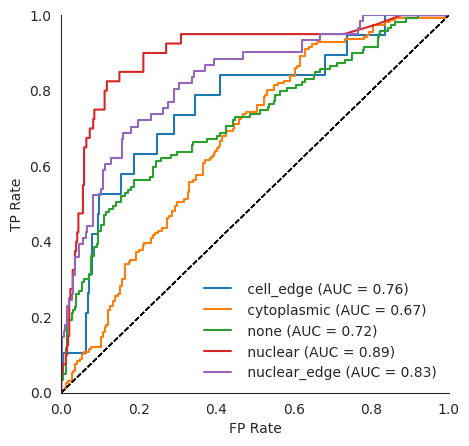

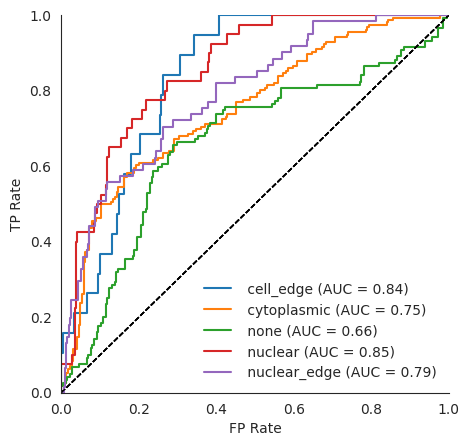

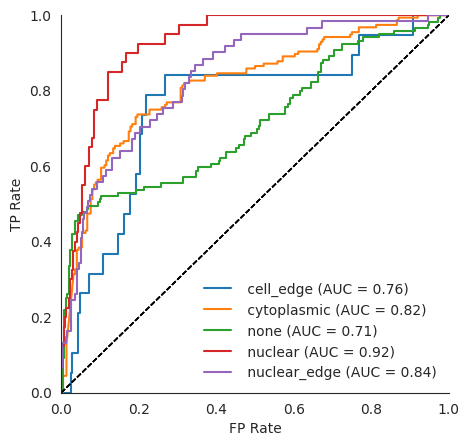

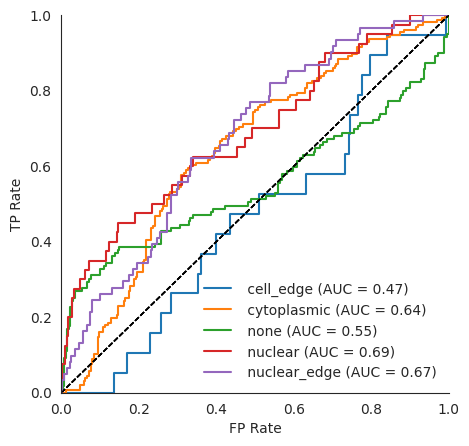

In [ ]:
with sns.axes_style("white"):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for cname, ax in zip(classifier_names, axes):

        colors = sns.color_palette(n_colors=len(patterns))
        for i, color in zip(range(len(patterns)), colors):
            ax.plot(
                fpr[cname][i],
                tpr[cname][i],
                color=color,
                lw=1.5,
                label=" {0} (AUC = {1:0.2f})" "".format(patterns[i], roc_auc[cname][i]),
            )

        ax.plot([0, 1], [0, 1], "k--", lw=1)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(cname)
        #         plt.legend(loc="lower right")
        sns.despine()


## Precision Recall

In [53]:
from sklearn.metrics import (
    PrecisionRecallDisplay,
    average_precision_score,
    f1_score,
    precision_recall_curve,
)

# For each class
precision = dict()
recall = dict()
average_precision = dict()
macro_f1 = dict()

for c, cname, pred in zip(classifiers, classifier_names, predict):
    precision[cname] = dict()
    recall[cname] = dict()
    average_precision[cname] = dict()

    for i in range(len(patterns)):
        precision[cname][i], recall[cname][i], _ = precision_recall_curve(
            y_merfish.values[:, i], pred[:, i]
        )
        average_precision[cname][i] = average_precision_score(
            y_merfish.values[:, i], pred[:, i]
        )

    # A "micro-average": quantifying score on all classes jointly
    precision[cname]["micro"], recall[cname]["micro"], _ = precision_recall_curve(
        y_merfish.values.ravel(), pred.ravel()
    )
    average_precision[cname]["micro"] = average_precision_score(
        y_merfish.values, pred, average="micro"
    )

    macro_f1[cname] = f1_score(y_merfish.values, pred > 0.5, average="macro")


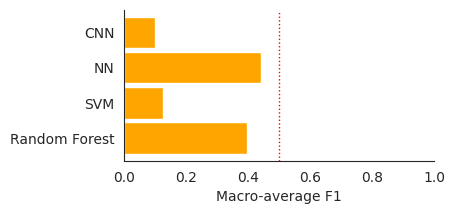

In [54]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(4, 2))
    ax.barh(
        y=list(macro_f1.keys()),
        width=macro_f1.values(),
        height=0.9,
        color="orange",
    )
    ax.axvline(0.5, color="red", linestyle=":", lw=1)
    sns.despine()
    plt.xlim(0, 1)
    ax.set_xlabel("Macro-average F1")


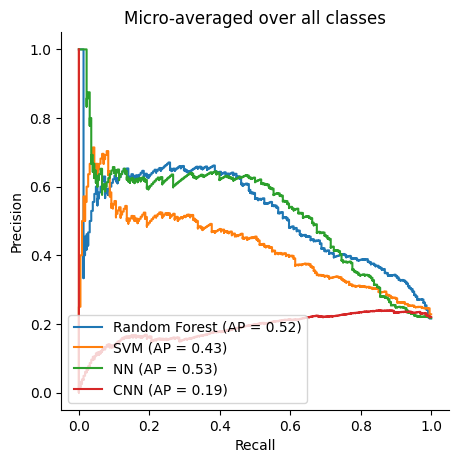

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for cname in classifier_names:
    display = PrecisionRecallDisplay(
        recall=recall[cname]["micro"],
        precision=precision[cname]["micro"],
        average_precision=average_precision[cname]["micro"],
    )
    display.plot(ax=ax, name=cname)
    _ = display.ax_.set_title("Micro-averaged over all classes")

sns.despine()


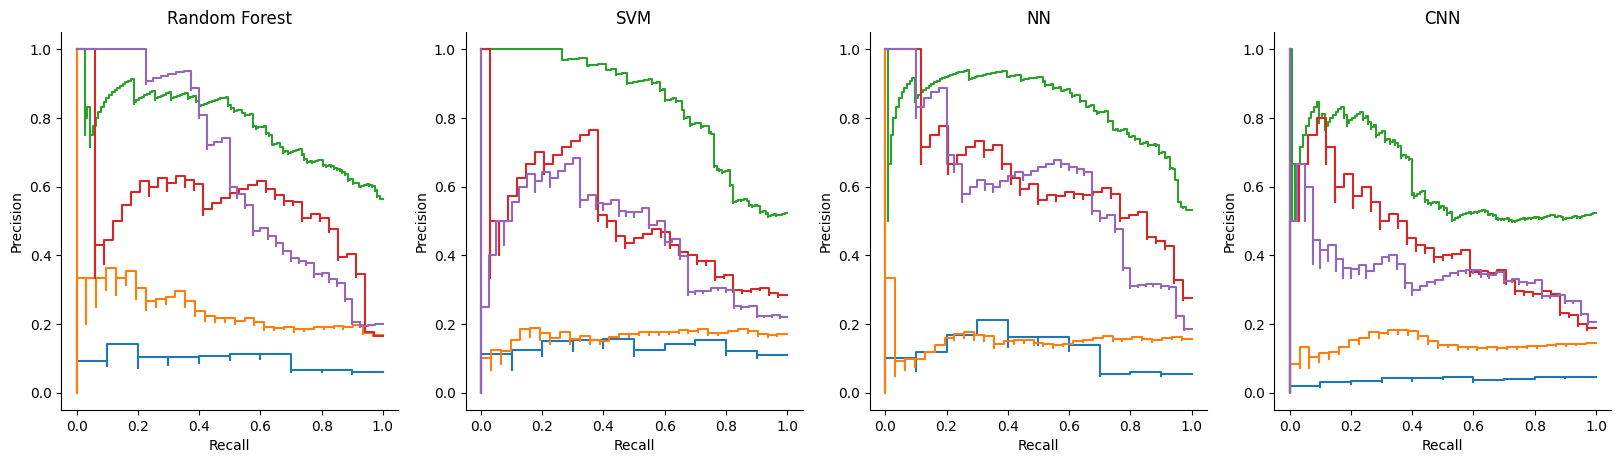

In [56]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for cname, ax in zip(classifier_names, axes):

    for i, color in zip(range(len(patterns)), colors):
        display = PrecisionRecallDisplay(
            recall=recall[cname][i],
            precision=precision[cname][i],
            average_precision=average_precision[cname][i],
        )
        display.plot(ax=ax, name=f"{patterns[i]}", color=color)
        ax.set_title(cname)
        ax.get_legend().remove()
    sns.despine()


## Sparsity Analysis

In [57]:
read_scores = dict()
for c, cname, pred in zip(classifiers, classifier_names, predict):
    read_scores[cname] = []
    for i in tqdm(range(len(patterns))):
        for threshold in range(5, 100, 2):
            count_mask = (counts_merfish <= threshold).values.flatten().tolist()
            score = f1_score(
                y_merfish.values[count_mask, i],
                pred[count_mask, i] > 0.5,
                average="micro",
            )
            read_scores[cname].append([patterns[i], threshold, score])
    read_scores[cname] = pd.DataFrame(
        read_scores[cname], columns=["pattern", "min_count", "f1score"]
    )


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

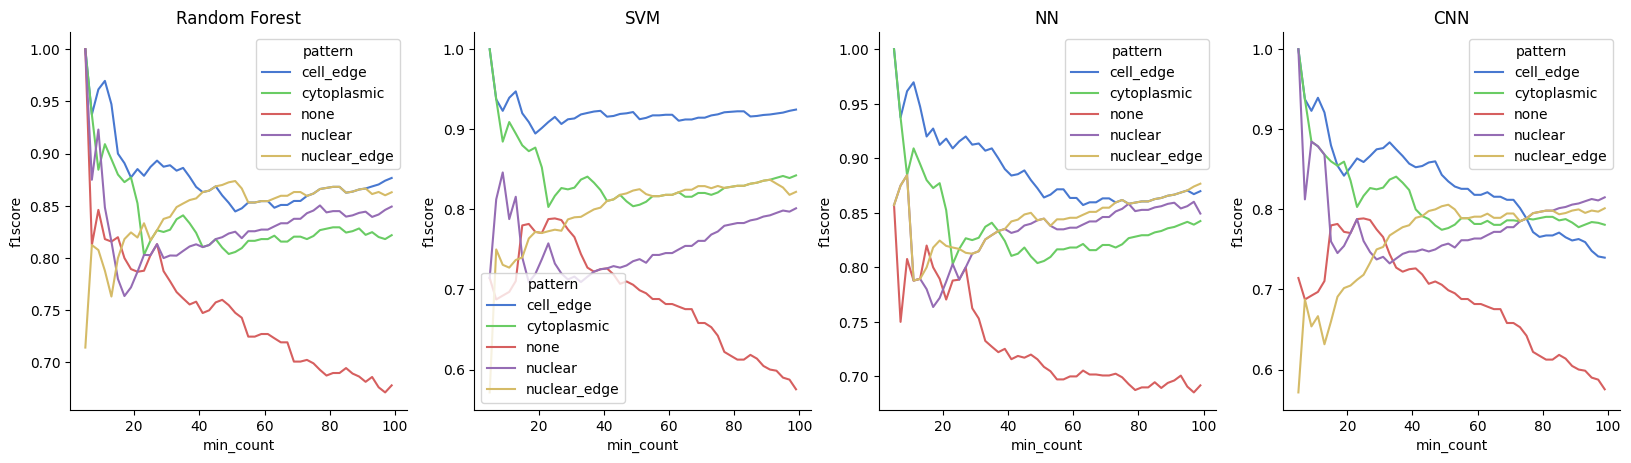

In [58]:
fig, axes = plt.subplots(1, len(read_scores), figsize=(20, 5))

for (cname, score_df), ax in zip(read_scores.items(), axes):
    sns.lineplot(
        data=score_df,
        x="min_count",
        y="f1score",
        hue="pattern",
        palette="muted6",
        ax=ax,
        #         legend=False,
    )
    ax.set_title(cname)
    sns.despine()
